# ORIE 5355/INFO 5370 HW 2: Recommendation systems

 - Name: Saketh Pabolu
 - Net-id: smp382
 - Date: Sept 29, 2025
 - Late days used for this assignment: N/A
 - Total late days used (counting this assignment): N/A
 - People with whom you discussed this assignment: N/A

After you finish the homework, please complete the following (short, anonymous) post-homework [survey](https://forms.gle/tnu9bTtT2kQDxZoU9) and include the survey completion code below.

### Question 0 [1 points]
<font color='green'> Survey completion code: `hw22022xyz`

We have marked questions in <font color='green'> green</font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2025/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='green'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

They use a hybrid model. They use latent factors from collaborative filtering plus explicit features (profile answers, item attributes, text/image embeddings) in a mixed-effects setup. That way, new users/items can be scored from features (solving cold start) while history refines the latent vectors over time.

<font color='green'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?

They compute a client-stylist match score and solve a capacity-constrained assignment (basically max-weight matching / min-cost flow, like the Hungarian/b-matching stuff from class). Stylists have limited slots, clients each get one stylist.

<font color='green'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

They forecast demand using client state/Markov models, then optimize purchasing and allocation to balance ordering and holding costs. They also generate new styles (inspired from genetic-algorithm) guided by predicted “fitness,” so future inventory matches what people will want.

# Programming component

## Helper code

In [263]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
np.set_printoptions(precision=3, suppress=True)
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'rating_all_zero'):
    # ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return book_vectors, user_vectors

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. A user may have interacted with a book, even if they never left any explicit rating or review. Ratings actually left by users range from 1 to 5 (stars), with 5 being the most positive and 1 being the most negative.

Here, we work with multiple types of data that capture interactions between books and users as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 2 types of rating/interaction data:
  
 - `Rating_all_missing_zero`: Numeric values more than 0 indicate the star ratings given. Missing values are replaced with 0's, so that there are no missing ratings. In another word, if a user has not left any reviews for a book, we assume that the user would rate the book 0 star.
 
 - `Rating_interaction_zero`: Numeric values more than 0 indicate the ratings given. Now, we replace missing values with 0's, _only if the user interacted with that book in the past_. In other words, if a user has not left any reviews for a book *and* has interacted with the book, we assume that the user would rate the book 0 star. Note that after such replacement, we would still get some missing values, since not all users have interacted with all the books.

In [264]:
book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')

In [265]:
def get_shapes_and_ranges(book_vectors, item_vectors):
    print(np.shape(book_vectors), np.shape(item_vectors))

In [266]:
get_shapes_and_ranges(book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(book_vectors_interact0, user_vectors_interact0)

(200, 10) (1000, 10)
(200, 10) (1000, 10)


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='green'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences. 

If a user interacted with a book, but didn't leave an explicit rating, we treat it as an implicit neutral signal (0) instead of N/A or missing. This leverages implicit feedback to separate items a user has seen and passed on from items they’ve never considered. It reduces popularity bias from pure missingness while still learning from exposure.

<font color='green'> What are some potential problems you see with using `Rating_all_missing_zero` for recommendations? Answer in no more than 3 sentences.
    
    

It assumes the users have interacted or have been exposed to the book. And, filling all missing ratings with 0 collapses “never seen” into “disliked,” which can punish long-tail items and new books. Cannot differenaitate between users who have never seen the book and users who have seen the book but did not leave a review. It inflates the volume of zeros relative to observed ratings, biasing factorization toward predicting low scores. It can also drown out true positive signals by overwhelming them with synthetic zeros.

### 1b) Generating predictions

<font color='green'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [267]:
def get_predictions(user_vectors, book_vectors):
    return user_vectors @ book_vectors.T

In [268]:
pred_all0 = get_predictions(user_vectors_allmissing0, book_vectors_allmissing0)        # (1000, 200)
pred_int0 = get_predictions(user_vectors_interact0, book_vectors_interact0)        # (1000, 200)

<font color='green'> Output the predictions for first 10 items for the first user, using each of the 2 data types.

For example, the predictions for one of the data types are:

Ratings for first 10 items, Ratings_all_missing_zero:

[ 0.08   0.29   0.063  1.57  -0.186  0.055  0.011 -0.088 -0.895 -0.012]

In [269]:
print("First user, first 10 predicted ratings (rating_all_missing_zero):")
print(pred_all0[0, :10])
print("First user, first 10 predicted ratings (rating_interaction_zero):")
print(pred_int0[0, :10])


First user, first 10 predicted ratings (rating_all_missing_zero):
[ 0.08   0.29   0.063  1.57  -0.186  0.055  0.011 -0.088 -0.895 -0.012]
First user, first 10 predicted ratings (rating_interaction_zero):
[-1.009  4.167 -0.919 -0.302 -2.526 -0.189 -3.081 -0.537 -1.186 -1.218]


<font color='green'> Do a scatterplot of the predicted rating for two data types. (Each dot represents one user and one book, with X axis being predicted ratings using `Rating_interaction_zero` data and Y axis being predicted rating using `Rating_all_missing_zero` ratings). Describe what you see in no more than 2 sentences. 

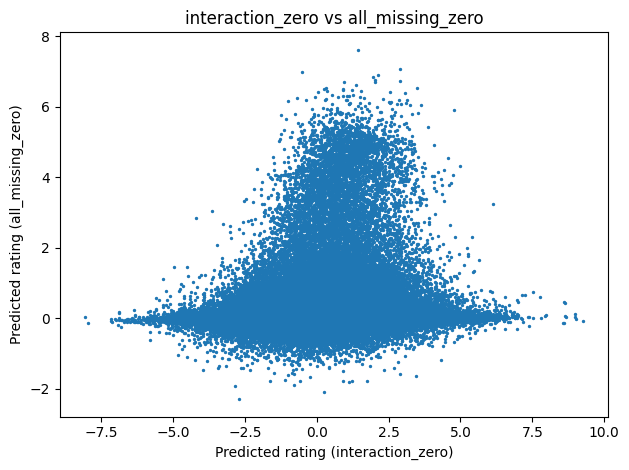

In [270]:
plt.figure()
plt.scatter(pred_int0.ravel(), pred_all0.ravel(), s=2)
plt.xlabel("Predicted rating (interaction_zero)")
plt.ylabel("Predicted rating (all_missing_zero)")
plt.title("interaction_zero vs all_missing_zero")
plt.tight_layout()
plt.show()

The relationship is noisy but positively sloped: items/users that score high in one model often score higher in the other, but with many deviations. The interaction-based model spreads scores more widely (including larger positives), reflecting the use of implicit negatives only where exposures occurred.

### 1c) From predictions to recommendations (without capacity constraints)

<font color='green'> Fill in the following function that takes in the matrix of predicted ratings for each user and item, and returns a dictionary where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [271]:
def get_recommendations_for_each_user(predictions):
    recommendations = {}
    for user_id in range(predictions.shape[0]):
        sorted_items = np.argsort(-predictions[user_id])
        
        top_items = sorted_items[:10]
        recommendations[user_id] = top_items.tolist()
    return recommendations

<font color='green'> Output the recommendations for the first user, using each of the 2 data types.

For example, from the `Ratings_all_missing_zero` dataset, you should get: [57, 55, 56, 81, 50, 78, 58, 86, 77, 96]

In [272]:
recs_all0 = get_recommendations_for_each_user(pred_all0)
recs_int0 = get_recommendations_for_each_user(pred_int0)

print("Top-10 recommendations for user 0 (rating_all_missing_zero):")
print(recs_all0[0]) # matches the example above so yay
print("Top-10 recommendations for user 0 (rating_interaction_zero):")
print(recs_int0[0])

Top-10 recommendations for user 0 (rating_all_missing_zero):
[57, 55, 56, 81, 50, 78, 58, 86, 77, 96]
Top-10 recommendations for user 0 (rating_interaction_zero):
[166, 53, 1, 111, 170, 74, 182, 37, 73, 52]


<font color='green'> Fill in the following function that takes in the (top 10) recommendations for each user, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

In [273]:
from collections import Counter

def show_frequency_histograms(recommendations, title):
    all_recommended_items = []
    for user_id in recommendations:
        all_recommended_items.extend(recommendations[user_id])
    
    item_counts = Counter(all_recommended_items)
    
    frequencies = []
    for book_id in range(200):
        frequencies.append(item_counts.get(book_id, 0))
    
    frequency_counts = Counter(frequencies)
    
    plt.figure(figsize=(5, 3))
    
    xs = sorted(frequency_counts.keys())
    ys = []
    for x in xs:
        ys.append(frequency_counts[x])
    plt.bar(xs, ys)


    plt.xlabel('# of times recommended')
    plt.ylabel('# of books')
    plt.title('Histogram of recommendation frequencies: ' + str(title))
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

<font color='green'> Show the histograms for both data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

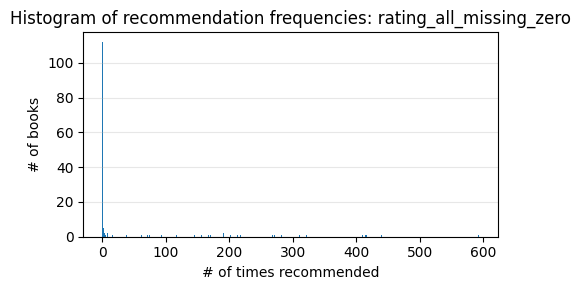

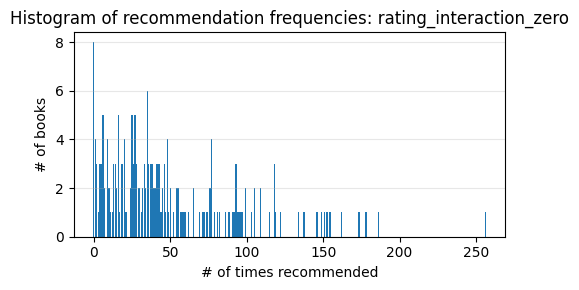

In [274]:
show_frequency_histograms(recs_all0, title="rating_all_missing_zero")
show_frequency_histograms(recs_int0, title="rating_interaction_zero")

A small subset of items appears very frequently, while most items are rarely (or never) in top-10 lists. In `all_missing_zero` graph, the data on the left of the chart is a bit more concentrated which is consistent with the zero-fill of all missing values pushing the model toward safer, popular items. This concentration can be good for conversion when inventory is ample, but risky when capacity is limited or diversity matters.

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [275]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the `Rating_interaction_zero` data.

In [276]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='green'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='green'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of about 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

For example, using this method, you should find that the vector for the second user (index "1") is:

array([-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02 ,  0.137,
       -0.12 ,  0.022])

Note: our answers below are based on the median _not rounded_ to 2 decimal places, i.e., we use the full median to many decimal places.

In [277]:
median_wealth = existing_user_demographics.Wealth.median()
median_wealth

np.float64(1.7026180771992308)

In [278]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    is_high = new_user["Wealth"] > median_wealth
    mask = (existing_user_demographics["Wealth"] > median_wealth) if is_high else (existing_user_demographics["Wealth"] <= median_wealth)
    mean_vec = existing_user_vectors[mask.values, :].mean(axis=0)
    return mean_vec

In [279]:
mask_low = existing_user_demographics["Wealth"] <= median_wealth
mask_high = ~mask_low
mean_low = existing_user_vectors[mask_low.values, :].mean(axis=0)
mean_high = existing_user_vectors[mask_high.values, :].mean(axis=0)

<font color='green'> Output the mean vector predicted for the first user (index 0) in `new_user_demographics`. 

In [280]:
vec_first_new = get_user_vector_for_new_user(new_user_demographics.iloc[0], existing_user_demographics, existing_user_vectors)
print("predicted vector for new_user_demographics [0]:")
print(vec_first_new)

predicted vector for new_user_demographics [0]:
[ 0.088 -0.207 -0.178 -0.131 -0.089 -0.127 -0.122 -0.427 -0.058 -0.106]


<font color='green'> For each of the 100 "new" users, use either your model to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. 

Plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

For example, for the first user-item pair (index 0 user, index 0 user), your prediction using the basic demographic should be -0.0011, and using the full model should be 0.3144. So one point in the scatter plot would be (-0.0011, 0.3144).

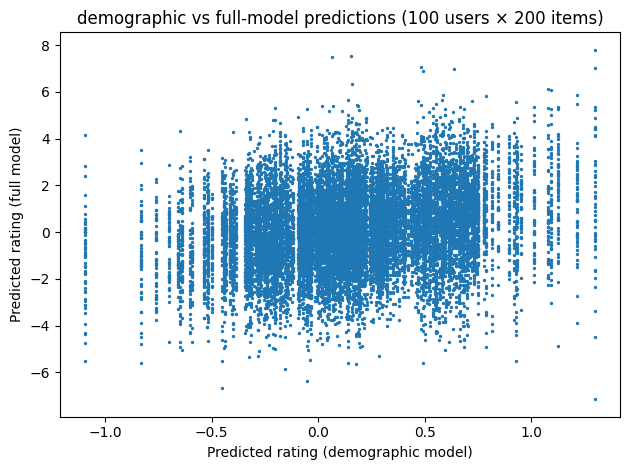

In [ ]:
pred_new_user_vectors_simple = np.vstack([
    get_user_vector_for_new_user(new_user_demographics.iloc[i], existing_user_demographics, existing_user_vectors)
    for i in range(len(new_user_demographics))
])

pred_demo_100x200 = get_predictions(pred_new_user_vectors_simple, book_vectors_interact0) 
true_user_vectors_last100 = user_vectors_interact0[900:, :]
pred_full_100x200 = get_predictions(true_user_vectors_last100, book_vectors_interact0)

plt.figure()
plt.scatter(pred_demo_100x200.ravel(), pred_full_100x200.ravel(), s=2)
plt.xlabel("Predicted rating (demographic model)")
plt.ylabel("Predicted rating (full model)")
plt.title("demographic vs full-model predictions (100 users x 200 items)")
plt.tight_layout()
plt.show()  

<font color='green'> Comment on the above. What is the potential "loss" from using demogprahics since we do not have access to the full data?

The wealth-split collapses many distinct users onto just two prototypes, so it underfits user heterogeneity and shrinks the range of predicted ratings. Next, top-N recommendations may miss niche preferences the full model captures, reducing personalization until we collect behavior.

### 2b) [Bonus, 2 points] Predictions for new users [Using KNN or another model]

<font color='green'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='green'> Now, use K nearest neighbors or some other machine learning method, and report the same things as in 2a.
    
<font color='green'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [282]:
def _encode_demographics(df, fit_stats=None):
    age_dummies = pd.get_dummies(df["Age group"], prefix="age", drop_first=False)
    loc_dummies = pd.get_dummies(df["Location"], prefix="loc", drop_first=False)
    wealth = df[["Wealth"]].copy()
    if fit_stats is None:
        w_mean = wealth["Wealth"].mean()
        w_std = wealth["Wealth"].std(ddof=0)
        fit_stats = {
            "wealth_mean": float(w_mean),
            "wealth_std": float(w_std if w_std > 0 else 1.0),
            "age_cols": age_dummies.columns.tolist(),
            "loc_cols": loc_dummies.columns.tolist(),
        }
    
    age_dummies = age_dummies.reindex(columns=fit_stats["age_cols"], fill_value=0)
    loc_dummies = loc_dummies.reindex(columns=fit_stats["loc_cols"], fill_value=0)
    wealth_std = (wealth["Wealth"] - fit_stats["wealth_mean"]) / (fit_stats["wealth_std"] if fit_stats["wealth_std"] != 0 else 1.0)
    
    X = np.hstack([wealth_std.to_numpy().reshape(-1,1),
                   age_dummies.to_numpy(),
                   loc_dummies.to_numpy()])
    return X, fit_stats

X_existing, fit_stats = _encode_demographics(existing_user_demographics, fit_stats=None)
X_new, _ = _encode_demographics(new_user_demographics, fit_stats=fit_stats)

<font color='green'> Output the mean vector predicted for the first user in `new_user_demographics`. 

KNN-predicted vector for new_user_demographics index 0:
[ 0.237 -0.625 -0.182 -0.208  0.064 -0.472 -0.435 -0.955 -0.66  -0.327]


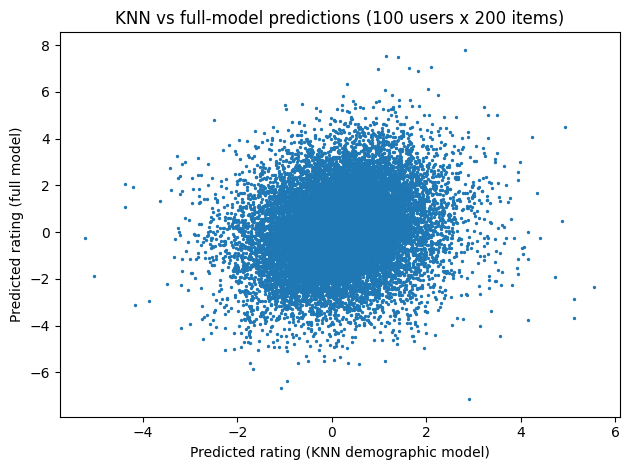

In [283]:
def get_user_vector_for_new_user_knn(new_user_vec, X_existing, existing_vectors):
    eps = 1e-6
    k = 10
    
    diffs = X_existing - new_user_vec  # (900, d)
    dists = np.sqrt(np.sum(diffs*diffs, axis=1))  # (900,)
    
    zero_mask = (dists < eps)
    
    if np.any(zero_mask):
        return existing_vectors[zero_mask, :].mean(axis=0)
    
    nn_idx = np.argpartition(dists, k-1)[:k]
    nn_d = dists[nn_idx]
    weights = 1.0 / (nn_d + eps)
    weights = weights / weights.sum()
    vec = (existing_vectors[nn_idx, :] * weights.reshape(-1,1)).sum(axis=0)
    return vec

pred_new_user_vectors_knn = np.vstack([
    get_user_vector_for_new_user_knn(X_new[i], X_existing, existing_user_vectors)
    for i in range(X_new.shape[0])
])

print("KNN-predicted vector for new_user_demographics index 0:")
print(np.round(pred_new_user_vectors_knn[0], 3))

pred_knn_100x200 = get_predictions(pred_new_user_vectors_knn, book_vectors_interact0)

plt.figure()
plt.scatter(pred_knn_100x200.ravel(), pred_full_100x200.ravel(), s=2)
plt.xlabel("Predicted rating (KNN demographic model)")
plt.ylabel("Predicted rating (full model)")
plt.title("KNN vs full-model predictions (100 users x 200 items)")
plt.tight_layout()
plt.show()

<font color='green'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

I used one-hot encoding on Age group and Location and standardized Wealth, then used Euclidean distance with k=10 and inverse-distance weighting. This lets nearby users in demographic space contribute more while still averaging to reduce variance. Compared to the two-bin wealth split, KNN gives me a richer continuum of user vectors and generally aligns better with the full model.

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='green'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='green'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
For example, you'll see that the first user was recommended their favorite item, but the last user was recommended their 129th favorite item. 


<font color='green'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

<font color='green'> In all cases, you will plot the rank according to the user's predicted ranking. 

Naive sequential: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


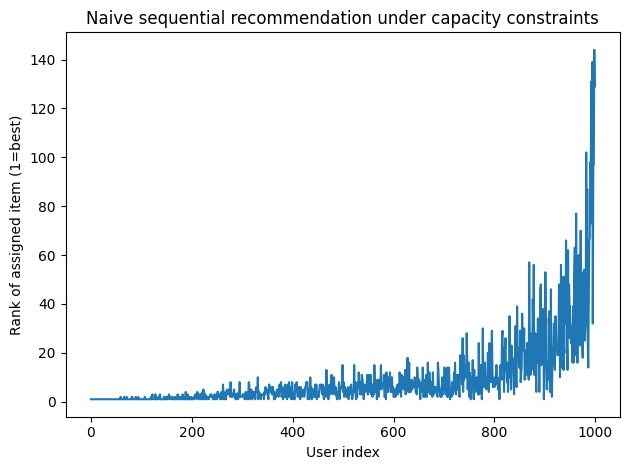

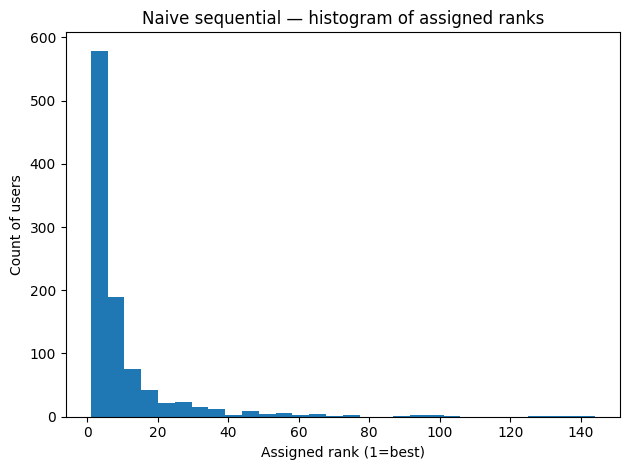

In [ ]:
predictions = pred_int0 
num_users, num_items = predictions.shape

ranked_items = []
for u in range(num_users):
    order = np.argsort(predictions[u])[::-1]
    ranked_items.append(order)

rank_of_item = np.zeros((num_users, num_items), dtype=int)
for u in range(num_users):
    rank = 1
    for item in ranked_items[u]:
        rank_of_item[u, item] = rank
        rank += 1

capacity = np.full(num_items, 5, dtype=int)
assigned_item = np.full(num_users, -1, dtype=int)
assigned_rank = np.full(num_users, -1, dtype=int)

for u in range(num_users):
    for item in ranked_items[u]:
        if capacity[item] > 0:
            assigned_item[u] = item
            assigned_rank[u] = rank_of_item[u, item]
            capacity[item] -= 1
            break

print("Naive sequential:", assigned_rank[:10].tolist())

plt.figure()
plt.plot(np.arange(num_users), assigned_rank)
plt.xlabel("User index")
plt.ylabel("Rank of assigned item (1=best)")
plt.title("Naive sequential recommendation under capacity constraints")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(assigned_rank, bins=30)
plt.xlabel("Assigned rank (1=best)")
plt.ylabel("Count of users")
plt.title("Naive sequential - histogram of assigned ranks")
plt.tight_layout()
plt.show()


### 3b) [Bonus -- 4 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[2 points] <font color='green'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='green'> Describe what you observe compared to the naive recommendations above. 
    
<font color='green'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

[2 points] <font color='green'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='green'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

### 3c) Score functions for recommendations under capacity constraints

<font color='green'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='green'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='green'> Implement the above and run the same simulation as part 3a, show the same two plots, and describe what you observe.

Note that, as above, you will plot the rank according to the user's predicted ranking, NOT the score function ranking. (Plotting by score function ranking will result in just a straight line where everyone gets their top ranked item, which is incorrect).

<font color='green'> For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{j}}} \sqrt{C_j} $$

HINT: In your code, for each user $i$ you will:
1. Retrieve the ratings ${r_{ij}}$ for each item $j$. 
2. Normalize each  ${r_{ij}}$ for by mean item rating $r_j$ and multiply by the sqrt of the current capacity for that item. 
3. Sort the items by the above modified score, and recommend the best item according to the modified score.

In [285]:
num_users, num_items = predictions.shape

pred_norm = pred_full.copy().astype(float)
mins = pred_norm.min(axis=0)
maxs = pred_norm.max(axis=0)
spans = np.where((maxs - mins) == 0, 1.0, (maxs - mins))
pred_norm = (pred_norm - mins) / spans
mean_item = pred_norm.mean(axis=0)
eps = 1e-6

capacity_sc = np.full(n_items, 5, dtype=int)
score_assigned_item = np.full(n_users, -1, dtype=int)
score_assigned_rank = np.full(n_users, -1, dtype=int)

In [286]:
for u in range(n_users):
    valid = capacity_sc > 0
    scores = np.full(n_items, -np.inf)
    tmp = (pred_norm[u, valid] / (mean_item[valid] + eps)) * np.sqrt(capacity_sc[valid])
    scores[valid] = tmp
    best_item = int(np.argmax(scores))
    score_assigned_item[u] = best_item
    score_assigned_rank[u] = rank_of_item[u, best_item]
    capacity_sc[best_item] -= 1

print("Score-function sequential:", score_assigned_rank[:10].tolist())

Score-function sequential: [1, 4, 3, 2, 5, 8, 1, 2, 2, 4]


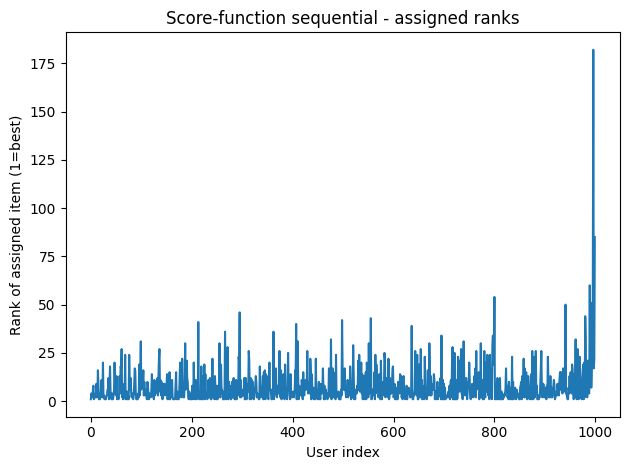

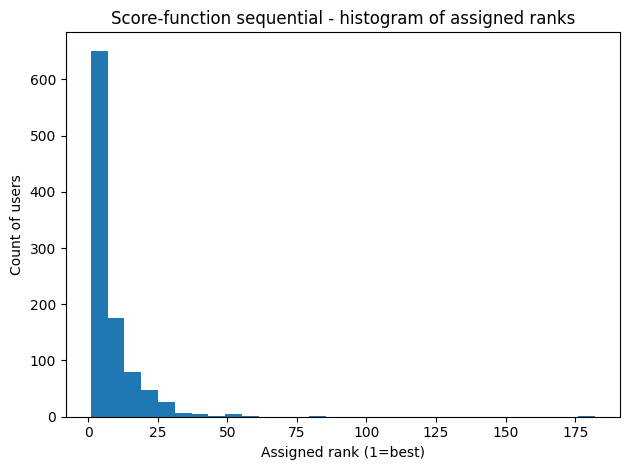

In [287]:
plt.figure()
plt.plot(np.arange(n_users), score_assigned_rank)
plt.xlabel("User index")
plt.ylabel("Rank of assigned item (1=best)")
plt.title("Score-function sequential - assigned ranks")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(score_assigned_rank, bins=30)
plt.xlabel("Assigned rank (1=best)")
plt.ylabel("Count of users")
plt.title("Score-function sequential - histogram of assigned ranks")
plt.tight_layout()
plt.show()

Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 